In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [7]:
#a) Load the oxford_iiit_pet dataset
import os

# Disable TFDS progress bars
os.environ['TFDS_TQDM'] = '0'
tfds.disable_progress_bar()

dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)
print(info)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Dataset oxford_iiit_pet downloaded and prepared to /Users/ajmaljalal/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/Users/ajmaljalal/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=()

In [8]:
def read_and_preprocess(data):
  input_image = tf.image.resize(data['image'], (128, 128))     #Resize the data['image'] to 128x128
  input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))     #Resize the data['segmentation_mask'] to 128x128

  input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
  input_mask -= 1 # {1,2,3} to {0,1,2}

  return input_image, input_mask

In [9]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

2025-11-10 19:38:54.276193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


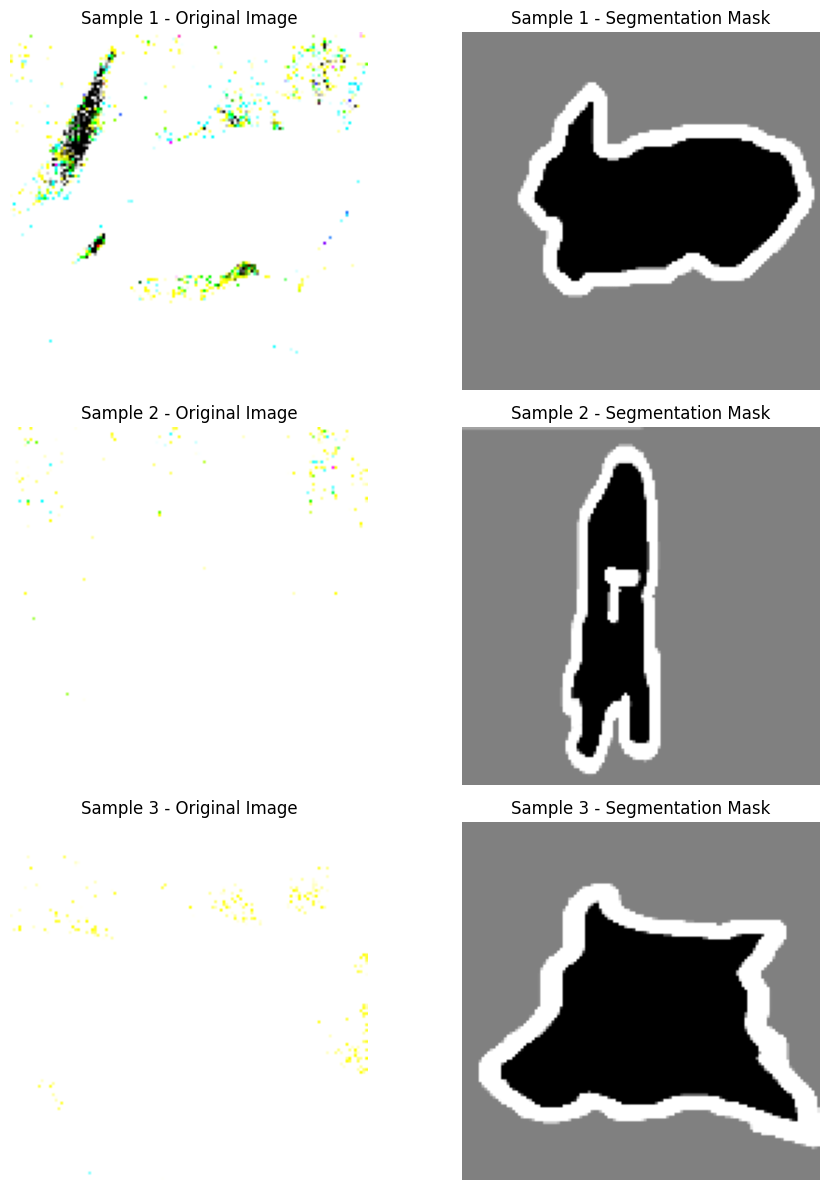

In [10]:
# b) Create the segmentation mask
# Show some images from dataset and their segmented version

# Take first 3 samples from the train dataset
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i, (image, mask) in enumerate(train.take(3)):
    # Display original image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f'Sample {i+1} - Original Image')
    axes[i, 0].axis('off')
    
    # Display segmentation mask
    axes[i, 1].imshow(mask[:, :, 0], cmap='gray')
    axes[i, 1].set_title(f'Sample {i+1} - Segmentation Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

**Part 2- Annotation**

In [ ]:
# Install mrcnn
%pip install -q scikit-image
%pip install -q git+https://github.com/matterport/Mask_RCNN.git

  DEPRECATION: Building 'mask-rcnn' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'mask-rcnn'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [12]:
# Get data from here https://github.com/experiencor/raccoon_dataset
!git clone https://github.com/experiencor/raccoon_dataset


Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Counting objects: 100% (646/646), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 646 (delta 413), reused 643 (delta 412), pack-reused 0 (from 0)
Receiving objects: 100% (646/646), 48.00 MiB | 8.42 MiB/s, done.
Resolving deltas: 100% (413/413), done.


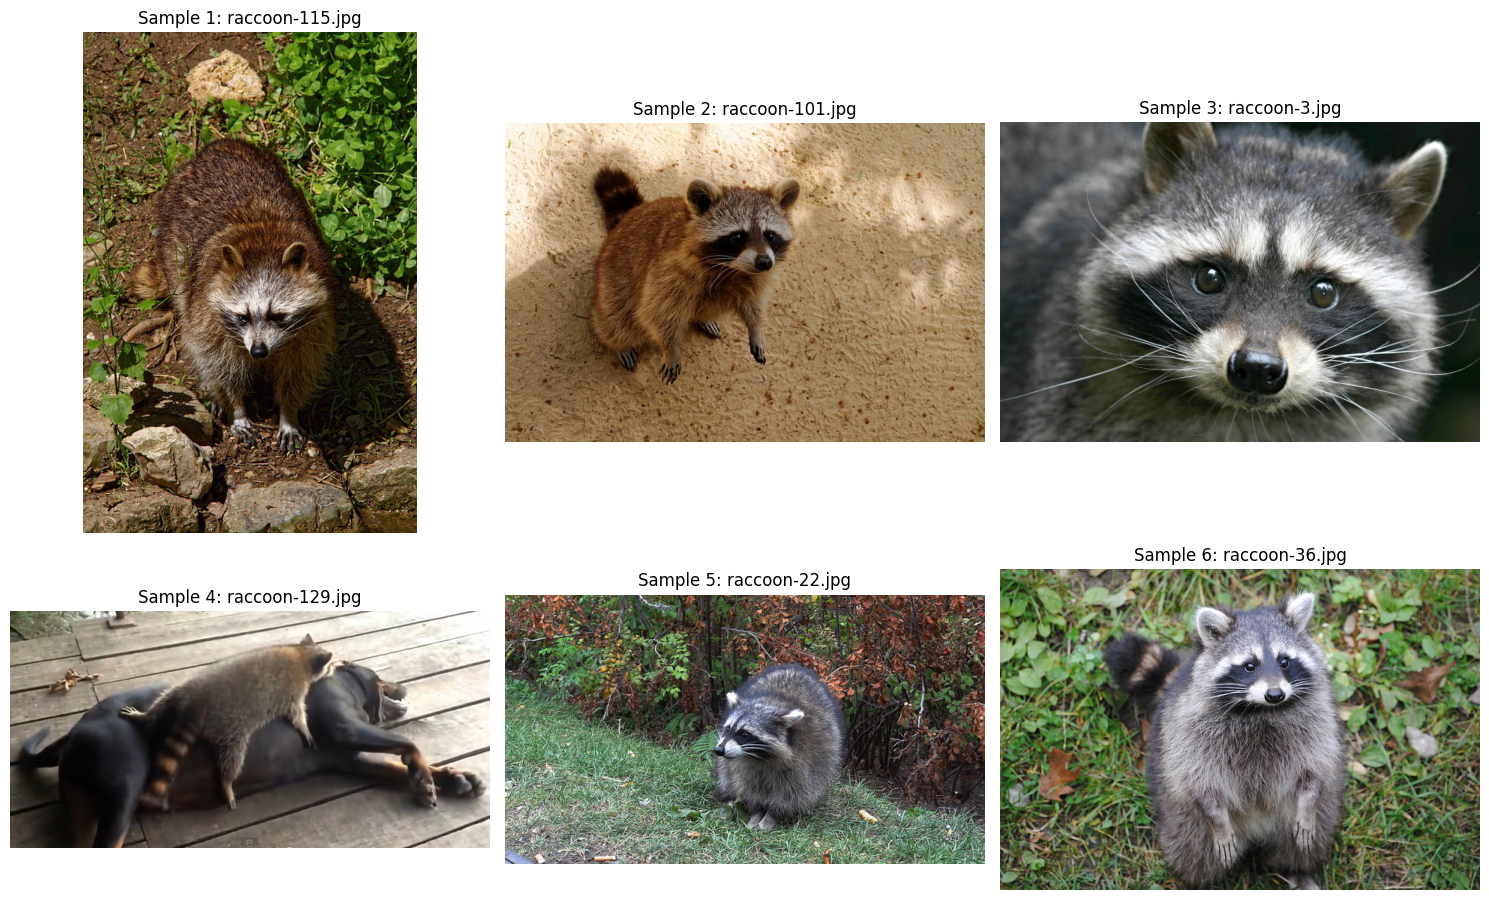

In [13]:
# Look into data
# Plot some samples here

import os
from PIL import Image

# Get list of images
image_dir = 'raccoon_dataset/images/'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')][:6]

# Display 6 sample images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f'Sample {i+1}: {img_file}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [15]:
%pip install -q scikit-image
%pip install -q git+https://github.com/matterport/Mask_RCNN.git


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("raccoon_dataset", 1, "raccoon")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/raccoon-'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[8:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		#path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   #Added by me
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('raccoon'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 149
Test: 51


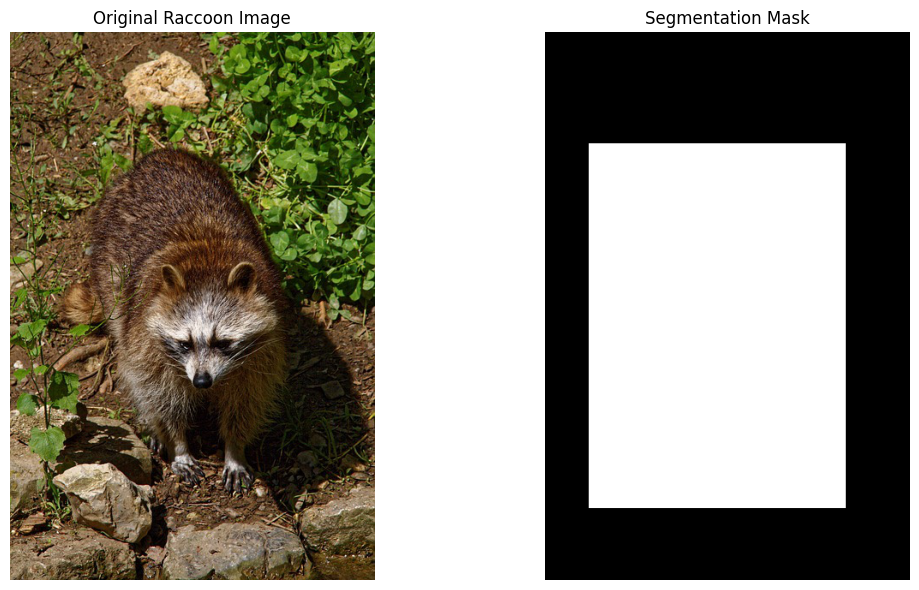

Image shape: (640, 426, 3)
Mask shape: (640, 426, 1)
Number of raccoons detected: 1


In [17]:
# load an image
# Use the function above to create the image and its mask

# Load a sample image (first image from train set)
image_id = 0
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)

# Display the image and its mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
axes[0].imshow(image)
axes[0].set_title('Original Raccoon Image')
axes[0].axis('off')

# Display mask (if multiple masks, combine them)
if mask.shape[2] > 0:
    combined_mask = np.sum(mask, axis=2)
    axes[1].imshow(combined_mask, cmap='gray')
    axes[1].set_title('Segmentation Mask')
else:
    axes[1].imshow(np.zeros_like(image[:,:,0]), cmap='gray')
    axes[1].set_title('No Mask Available')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Number of raccoons detected: {mask.shape[2]}")

**Part 3- YOLO**




You can see how YOLO has been improved in the last few versions on COCO: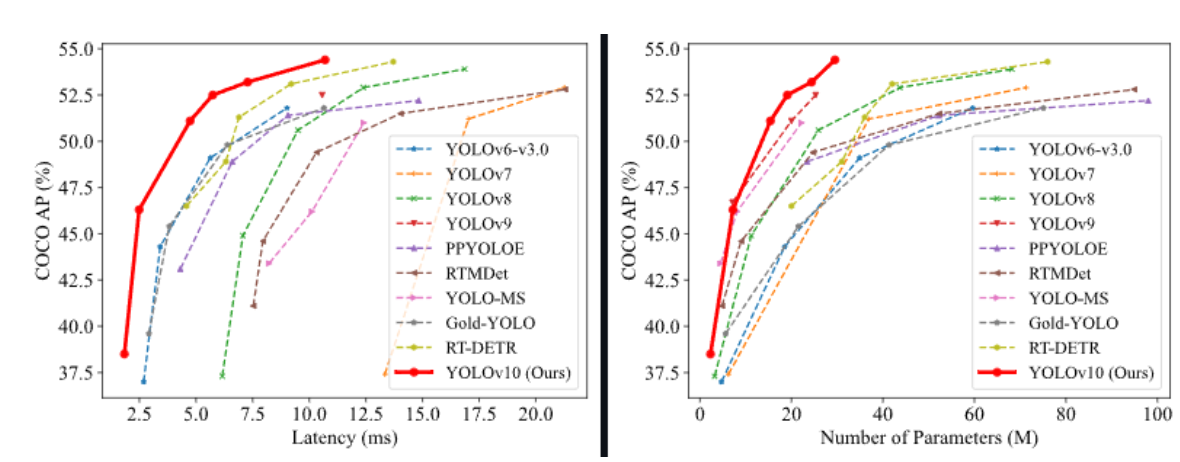

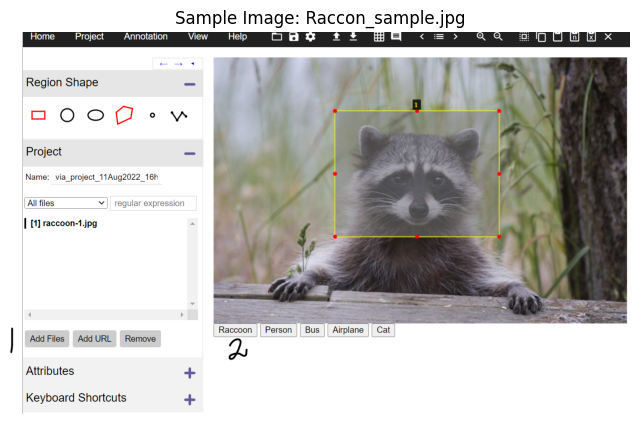

In [21]:
# a- Create annotation
# You can upload the file using ![title](filename.jpeg)
# import image module

from PIL import Image as PILImage
import matplotlib.pyplot as plt

# Display the sample raccoon image
img = PILImage.open('Raccon_sample.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title('Sample Image: Raccon_sample.jpg')
plt.axis('off')
plt.show()

In [ ]:
#b- Download required tools
import os
HOME = os.getcwd()
!pip install -U ultralytics

In [24]:
#c- Test the model out of box
import os
HOME = os.getcwd()

from ultralytics import YOLO
model = YOLO(f'{HOME}/weights/yolov10n.pt') # Load the yolov10n model
results = model.predict(source="https://ultralytics.com/images/bus.jpg", conf=0.25, save=True)
print(f"Results saved to: {results[0].save_dir}")


WARNING ⚠️ Download failure, retrying 1/3 https://ultralytics.com/images/bus.jpg... HTTP Error 403: Forbidden


######################################################################## 100.0%#=#=#                                                                          ##=#=#                                                                         


image 1/1 /Users/ajmaljalal/Desktop/ML & AI/Master Program/Semester_four/AAI_521/bus.jpg: 640x480 4 persons, 1 bus, 107.0ms
Speed: 5.7ms preprocess, 107.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /Users/ajmaljalal/Desktop/ML & AI/Master Program/Semester_four/AAI_521/runs/detect/predict
Results saved to: /Users/ajmaljalal/Desktop/ML & AI/Master Program/Semester_four/AAI_521/runs/detect/predict


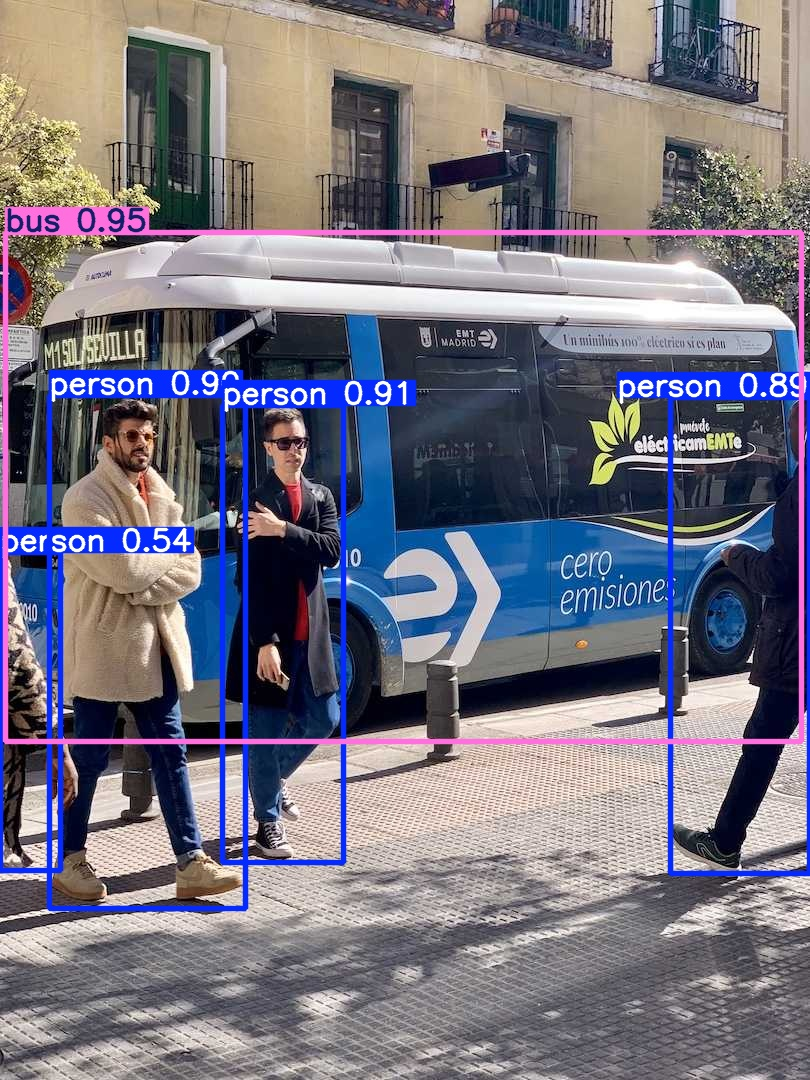

In [25]:
from IPython.display import Image
import os
HOME = os.getcwd()
Image(filename=f'{HOME}/runs/detect/predict/bus.jpg') # Display the prediction result

In [27]:
#d- Apply model here
import os
HOME = os.getcwd()
!yolo task=detect mode=train model="{HOME}/weights/yolov10n.pt" data=coco128.yaml epochs=10 batch=32 imgsz=640

Ultralytics 8.3.227 🚀 Python-3.12.5 torch-2.9.0 CPU (Apple M1 Max)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/Users/ajmaljalal/Desktop/ML & AI/Master Program/Semester_four/AAI_521/weights/yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pa

Confusion Matrix:


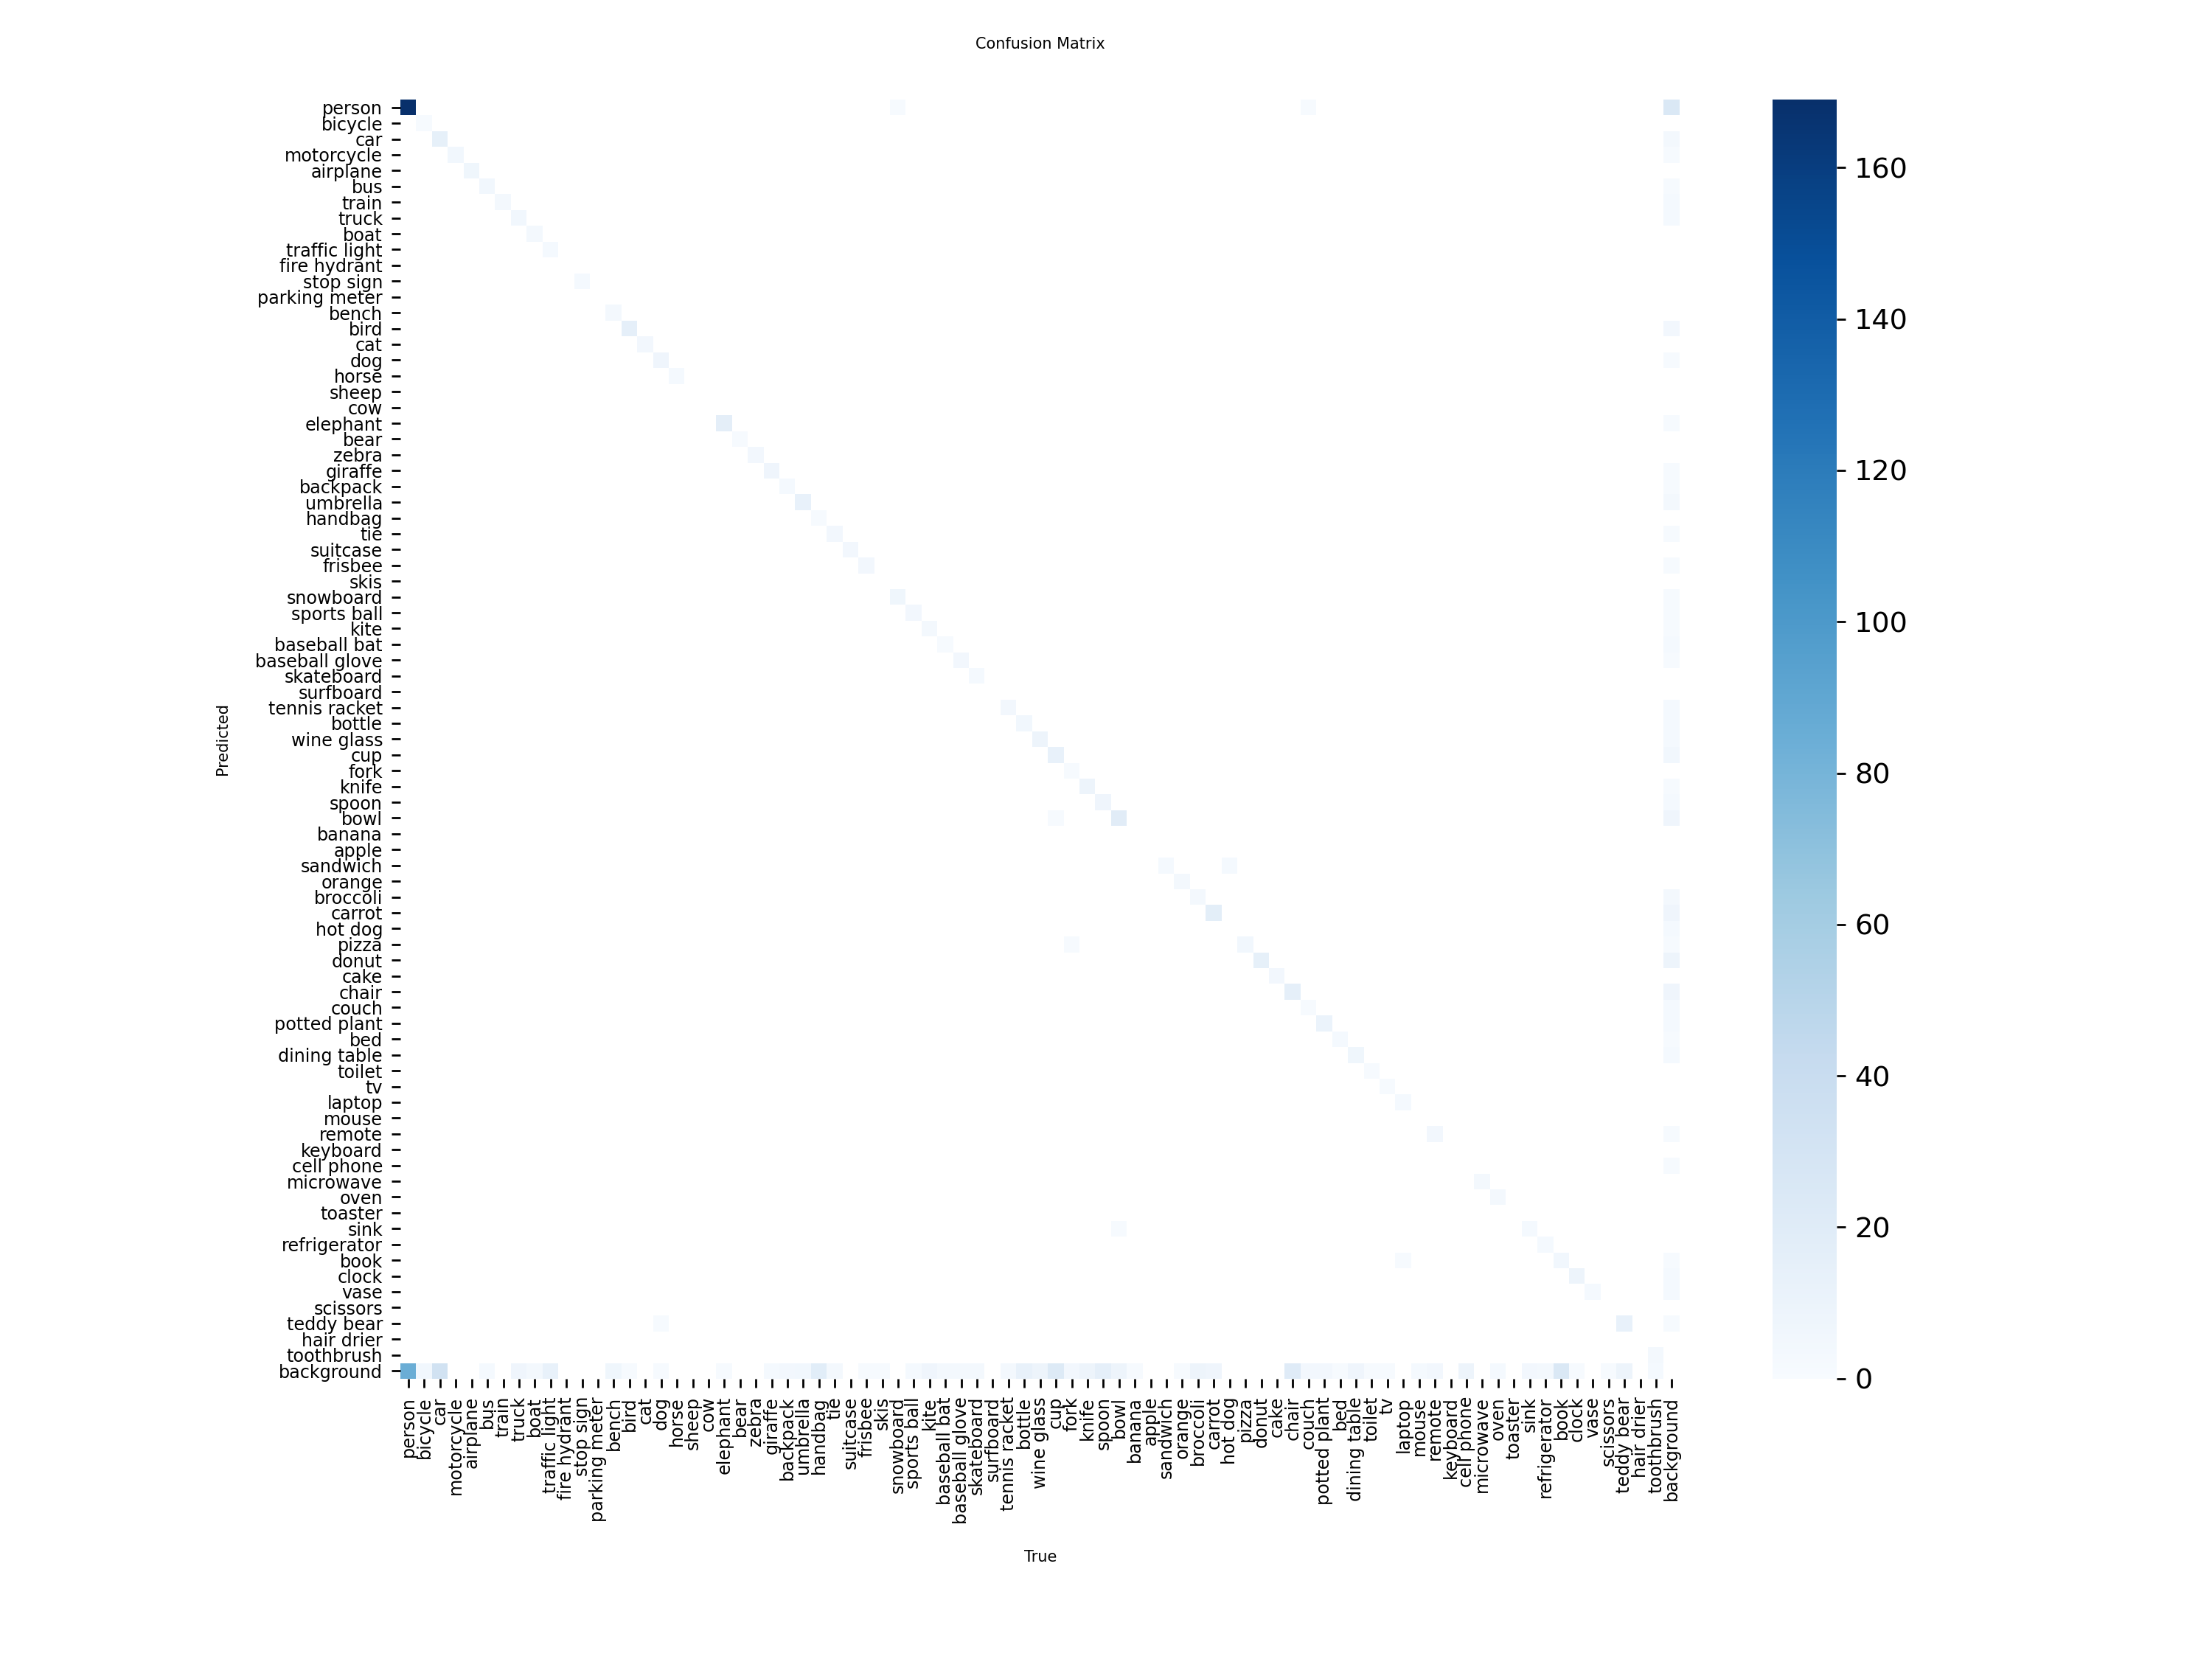


Learning Curves:


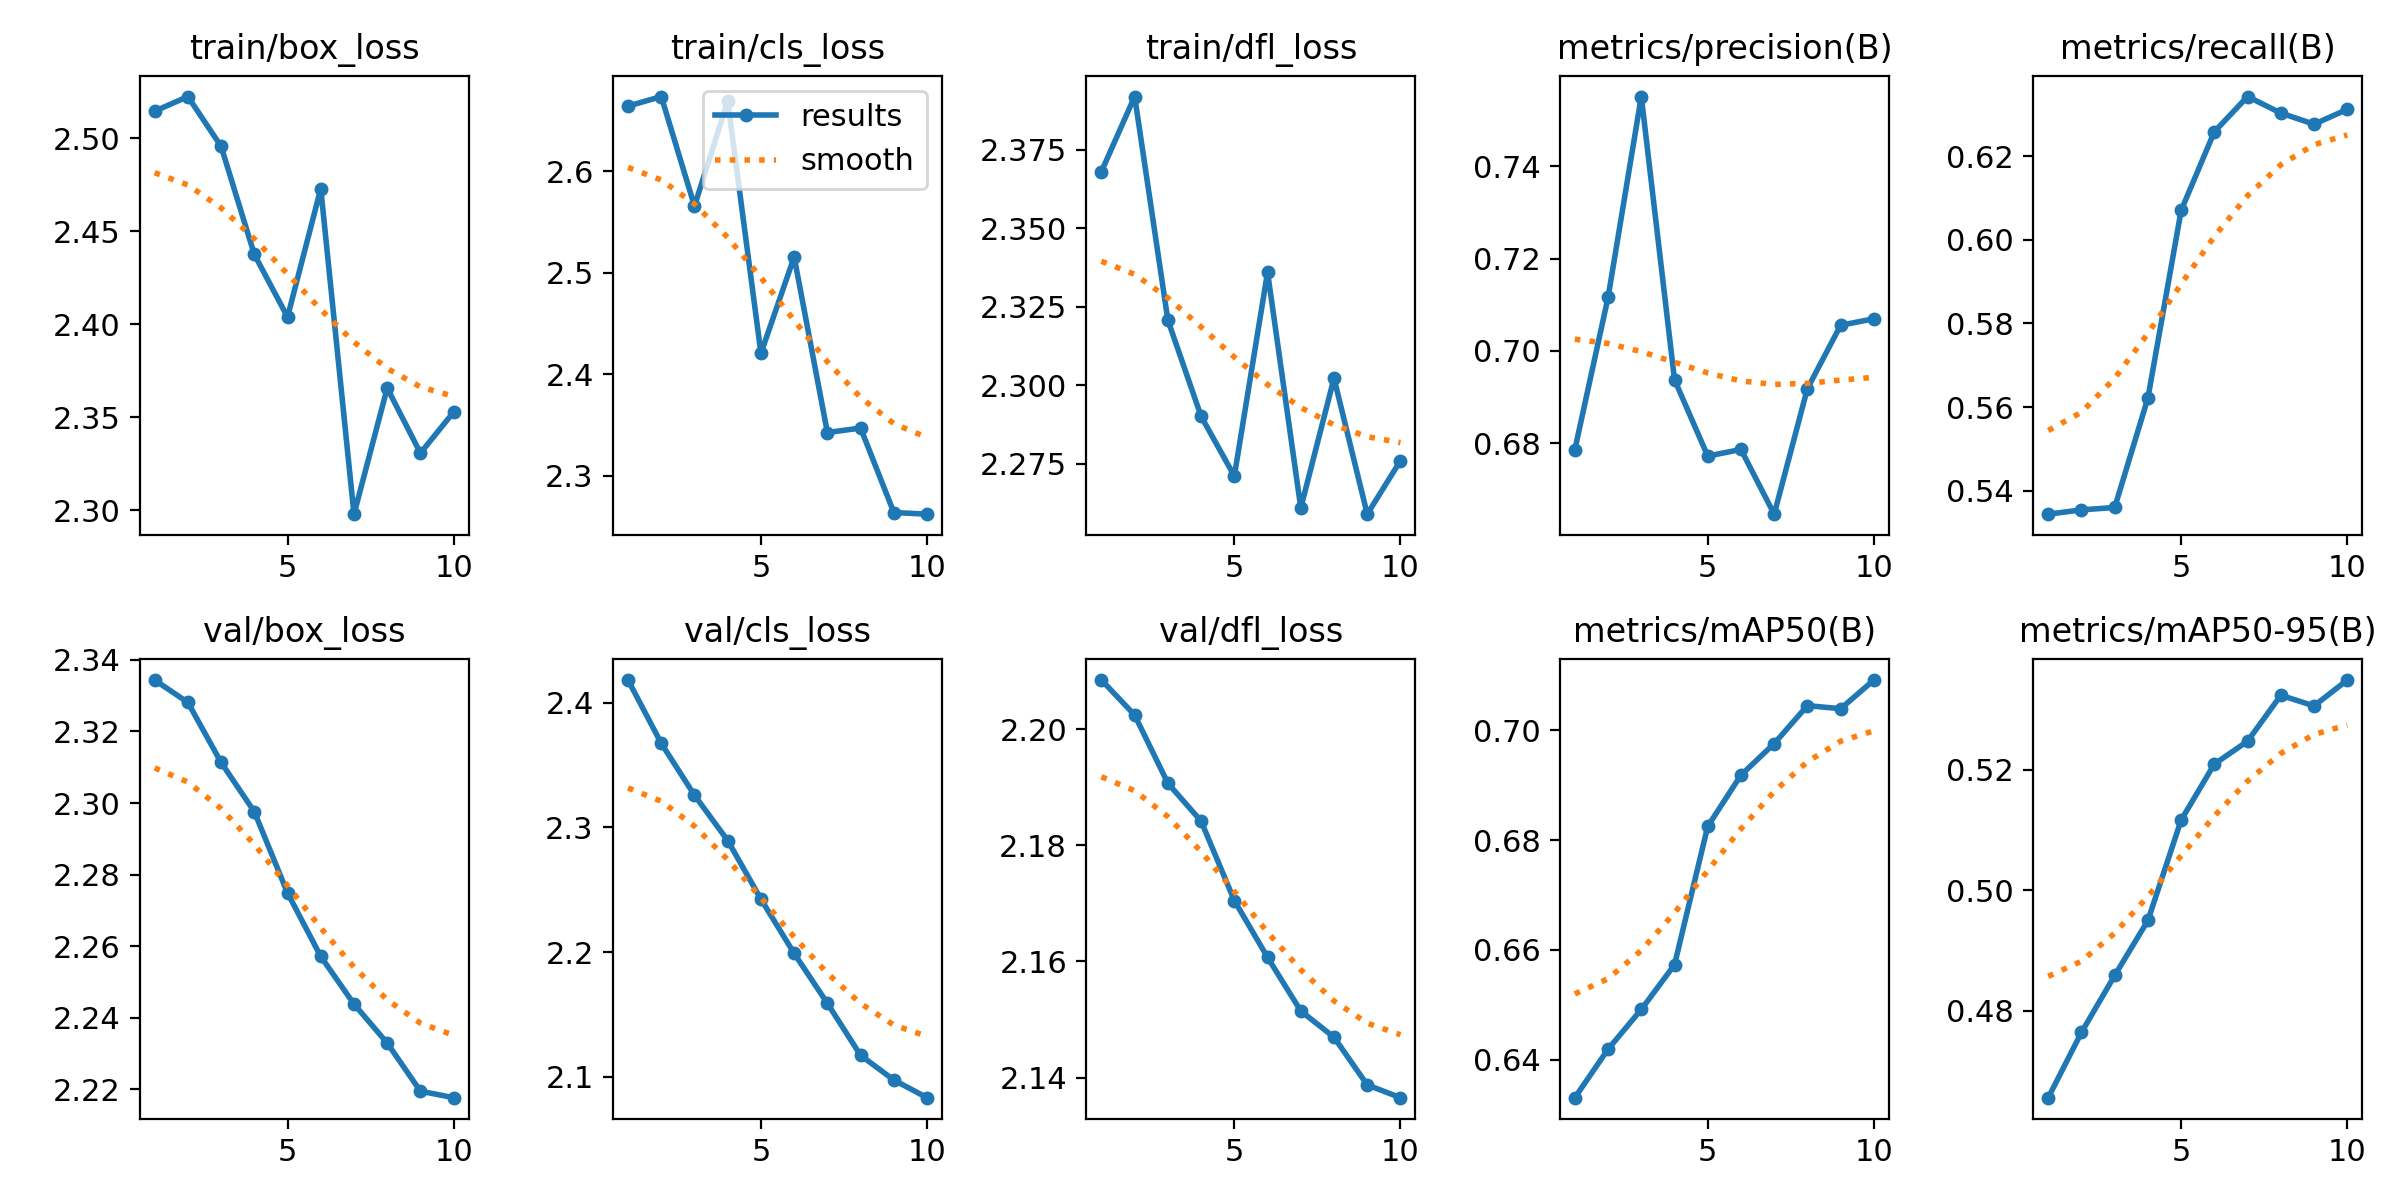

In [28]:
# Show the learning curve and confusion matrix
from IPython.display import Image, display
import os
HOME = os.getcwd()

print("Confusion Matrix:")
display(Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png'))

print("\nLearning Curves:")
display(Image(filename=f'{HOME}/runs/detect/train/results.png'))

# e- Explain what you see in the learning curves and confusion matrix.

## Analysis of Learning Curves and Confusion Matrix

The learning curves display key training metrics over 10 epochs. The loss curves show how well the model learns, with decreasing values indicating improvement. If training and validation losses remain close together, this suggests the model generalizes well without overfitting. The precision and recall metrics measure prediction accuracy and coverage respectively, with higher values indicating better performance. The mAP (mean Average Precision) scores at different IoU thresholds provide comprehensive measures of object detection accuracy.

The confusion matrix reveals the model's classification performance across different object classes. Values along the diagonal represent correct predictions, while off-diagonal elements show misclassifications and which classes the model confuses with each other. The background class row indicates how well the model distinguishes between objects and empty regions.

Overall, training on COCO128 with just 10 epochs provides a quick demonstration of fine-tuning YOLOv10n. While this limited training shows the process, more epochs would likely improve performance. The confusion matrix is particularly useful for identifying which object classes pose the greatest challenges for detection.